In [153]:
# crea graficos interactivos
%matplotlib inline
from astropy.io import fits #para acceder a los archivos FITS
from astropy.table import Table # para crear tablas ordenadas de los datos
import matplotlib.pyplot as plt # para plotear datos
import pandas as pd
import numpy as np
import glob
import math
import os
import random as rnd

In [154]:
from astroquery.mast import Mast
from astroquery.mast import Observations

Definimos las funciones para el manejo de ficheros locales

In [155]:
# Funcion para establecer el nombre de búsqueda en el MAST de un objeto kepler (KOI)
def get_koi_target_name(kepid):
    koi_target_name = "kplr" + format(kepid, '09')
    return koi_target_name

# Comprueba la existencia de ficheros fits para un KOI
def fits_file_exists(koi_target_name):
    fileFind = "./mastDownload/Kepler/" + koi_target_name + "*/*.fits"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# Comprueba la existencia de ficheros CSV para un KOI
def csv_file_exists(koi_target_name):
    fileFind = "./mastDownload/Bintables/" + koi_target_name + "*/*.csv"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# dado un id de kepler, obtenemos la lista de ficheros csv
def get_csv_from_koi(kepid):
    koi_target_name = get_koi_target_name(kepid)
    csvExists, csv_files = csv_file_exists(koi_target_name)
    return csv_files


En segundo lugar, las funciones que nos ayudarán a la extracción de ficheros FITS y su procesamiento a CSV

In [156]:
# dado el dataframe original descarga los ficheros fits que no estén
def download_fits_files(df_koi):
    for index in range(0, len(df_koi)):

        # Formateamos el id para que valga para hacer query
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)

        prod = None
        filename = None
        if not fitsExists:
            # Buscamos las observaciones que cadencia corta para el KOI actual
            keplerObs = Observations.query_criteria(
                target_name=koi_target_name,    # nombre del KOI formateado
                obs_id="*_sc_*",                # observaciones de cadencia corta
                obs_collection='Kepler'         # colección Kepler
            )
                
            if len(keplerObs) > 0 :
                # Buscamos los productos asociados a la observación de cadencia corta
                keplerProds = Observations.get_product_list(keplerObs[-1])
                keplerProds = Observations.filter_products(
                    keplerProds,            # productos de la observación
                    extension='_slc.fits',  # archivos fit de cadencia corta
                    mrp_only=False  
                )

                
                if len(keplerProds) > 0 :
                    filename = keplerProds[-1]["dataURI"].split("/")[-1]
                    # hay que repetir esta busqueda para sacar un unico fichero porque
                    # de otra manera da error de conversion
                    prod = Observations.filter_products(
                        keplerProds, 
                        extension=filename,
                        mrp_only=False
                    )

            if not prod is None:
                Observations.download_products(
                    prod, 
                    mrp_only = False, 
                    cache = True
                )
                glob.glob(filePath)

        else:
            filename = files[-1]


        df_koi["filename"][index] = filename

# dada la ruta local del fichero FITS, lo abre y obtenemos los datos que nos serán útiles
# en ocasiones no se puede abrir el fichero por ser de gran tamaño
def get_info_from_fits_file(file):
    try:
        bjdrefi = np.nan
        bjdreff = np.nan
        times = np.nan
        sap_fluxes = np.nan
        pdcsap_fluxes = np.nan

        with fits.open(file, lazy_load_hdus=True) as hdulist: 
            header1 = hdulist[1].header
            binaryext = hdulist[1].data

            # binarytable = Table(binaryext)
            # df_bintable = binarytable.to_pandas()

            # En la cabecera tenemos los datos "BJDREF"
            # es el desplazamiento en el array de tiempo (time)
            bjdrefi = header1['BJDREFI'] 
            bjdreff = header1['BJDREFF']

            # Obtenemos las columnas que nos serán relevantes
            times = binaryext['time'] 
            sap_fluxes = binaryext['SAP_FLUX']
            pdcsap_fluxes = binaryext['PDCSAP_FLUX']
    except:
        print(str(file) + " could not be opened")

    return bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes

# Obtiene ficheros CSV a partir de los ficheros FITS descargados
def proccess_fits_file_to_csv(df_koi, replaceCsv = False):
    df_koi["hasFits"] = 0
    df_koi["hasCsv"] = 0

    for index in df_koi.index: 
        
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)        

        if (fitsExists and not csvExists) or len(fits_files) != len(csv_files) or replaceCsv:
            # print(index, koi_target_name, fitsExists, csvExists,len(fits_files), len(csv_files), replaceCsv)

            for file in fits_files:
                # fits.info(file)

                # print(koi_target_name, file)
                
                bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes = get_info_from_fits_file(file)

                # Convert the time array to full BJD by adding the offset back in.
                bjds = times + bjdrefi + bjdreff 

                # Almacena todos los datos necesarios en un fichero csv
                data = {
                    "bjdrefi" : bjdrefi,
                    "bjdreff" : bjdreff,
                    "times" : times,
                    "bjds" : bjds,
                    "sap_fluxes" : sap_fluxes,
                    "pdcsap_fluxes" : pdcsap_fluxes
                } 
                df_bintable = pd.DataFrame(data, columns = ["bjdrefi", "bjdreff", "times", "bjds", "sap_fluxes", "pdcsap_fluxes"]) 

                csv_path = file.replace("Kepler", "Bintables").replace(".fits",".csv")
                if not os.path.exists(os.path.dirname(csv_path)):
                    os.makedirs(os.path.dirname(csv_path))
                df_bintable.to_csv(csv_path)

        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)
        df_koi["hasFits"][index] = len(fits_files)
        df_koi["hasCsv"][index] = len(csv_files)

        """    
        if index == 15:
            break
        """
    return df_koi

Establecemos otras funciones que nos ayudarán a mostrar los datos procesados en gráficas

In [157]:
# Pinta el gráfico de la curva de luz
def plot_light_curve(bjds, sap_fluxes, pdcsap_fluxes):
    plt.figure(figsize=(9,4))

    # Muestra el flujo de luz corregido y no corregido
    plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
    plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

    plt.title('Kepler Light Curve')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Flux (electrons/second)')
    plt.show()

# Pinta un grafico de un elemento aleatorio de un kepid
def get_random_plot_from_csv(df_koi_csv):
    rand_idx = rnd.choice(df_koi_csv.index)
    files = get_csv_from_koi(df_koi_csv["kepid"][rand_idx])
    df_csv = pd.read_csv(files[-1])

    # display(df_csv)
    display(df_koi_csv.loc[rand_idx, ["kepid", "kepoi_name", "kepler_name", "koi_disposition", "koi_pdisposition"]])
    plot_light_curve(df_csv["bjds"], df_csv["sap_fluxes"], df_csv["pdcsap_fluxes"])


Cargamos el fichero descargado del MAST con todos los KOI 

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

Este fichero contiene los identificadores de los KOI así como otra inforamción que nos será relevante como:
- Nombre del elemento para poder identificarlo más fácilmente
- 

In [158]:
newProcess = False
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)

if newProcess:
    download_fits_files(df_koi)
    df_koi_processed = proccess_fits_file_to_csv(df_koi, replaceCsv=False)
else:
    df_koi_processed = pd.read_csv("./mast-info-processed.csv")

display(df_koi_processed[:15])

Unnamed: 0     kepid kepoi_name   kepler_name koi_disposition  \
0            0  10797460  K00752.01  Kepler-227 b       CONFIRMED   
1            1  10797460  K00752.02  Kepler-227 c       CONFIRMED   
2            2  10811496  K00753.01           NaN       CANDIDATE   
3            3  10848459  K00754.01           NaN  FALSE POSITIVE   
4            4  10854555  K00755.01  Kepler-664 b       CONFIRMED   
5            5  10872983  K00756.01  Kepler-228 d       CONFIRMED   
6            6  10872983  K00756.02  Kepler-228 c       CONFIRMED   
7            7  10872983  K00756.03  Kepler-228 b       CONFIRMED   
8            8   6721123  K00114.01           NaN  FALSE POSITIVE   
9            9  10910878  K00757.01  Kepler-229 c       CONFIRMED   
10          10  11446443  K00001.01    Kepler-1 b       CONFIRMED   
11          11  10666592  K00002.01    Kepler-2 b       CONFIRMED   
12          12   6922244  K00010.01    Kepler-8 b       CONFIRMED   
13          13  10984090  K00112.02  Kepler-466 c       CONFIRMED   
14          14  10419211  K00742.01           NaN  FALSE POSITIVE   

   koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
0         CANDIDATE      1.000              0              0              0   
1         CANDIDATE      0.969              0              0              0   
2         CANDIDATE      0.000              0              0              0   
3    FALSE POSITIVE      0.000              0              1              0   
4         CANDIDATE      1.000              0              0              0   
5         CANDIDATE      1.000              0              0              0   
6         CANDIDATE      1.000              0              0              0   
7         CANDIDATE      0.992              0              0              0   
8    FALSE POSITIVE      0.000              0              1              1   
9         CANDIDATE      1.000              0              0              0   
10        CANDIDATE      0.811              0              0              0   
11        CANDIDATE      1.000              0              1              0   
12        CANDIDATE      0.998              0              0              0   
13        CANDIDATE      1.000              0              0              0   
14   FALSE POSITIVE      0.000              0              1              0   

    ...  koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  \
0   ...           0.064          -0.096     0.927          0.105   
1   ...           0.064          -0.096     0.927          0.105   
2   ...           0.044          -0.176     0.868          0.233   
3   ...           0.053          -0.168     0.791          0.201   
4   ...           0.070          -0.210     1.046          0.334   
5   ...           0.054          -0.229     0.972          0.315   
6   ...           0.054          -0.229     0.972          0.315   
7   ...           0.054          -0.229     0.972          0.315   
8   ...           0.182          -0.098     1.958          0.322   
9   ...           0.083          -0.028     0.848          0.033   
10  ...           0.024          -0.024     0.964          0.038   
11  ...           0.033          -0.027     1.952          0.099   
12  ...           0.055          -0.045     1.451          0.110   
13  ...           0.085          -0.114     1.022          0.143   
14  ...           0.033          -0.176     0.848          0.224   

    koi_srad_err2         ra        dec  koi_kepmag  hasFits  hasCsv  
0          -0.061  291.93423  48.141651      15.347        0       0  
1          -0.061  291.93423  48.141651      15.347        0       0  
2          -0.078  297.00482  48.134129      15.436        0       0  
3          -0.067  285.53461  48.285210      15.597        0       0  
4          -0.133  288.75488  48.226200      15.509        1       1  
5          -0.105  296.28613  48.224670      15.714        1       1  
6          -0.105  296.28613  48.224670      15.

In [159]:
df_koi_csv = df_koi_processed[df_koi_processed.hasCsv > 0]
display(df_koi_csv)
print(df_koi_csv["hasCsv"].sum(), "ficheros CSV disponibles")

Unnamed: 0     kepid kepoi_name   kepler_name koi_disposition  \
4              4  10854555  K00755.01  Kepler-664 b       CONFIRMED   
5              5  10872983  K00756.01  Kepler-228 d       CONFIRMED   
6              6  10872983  K00756.02  Kepler-228 c       CONFIRMED   
7              7  10872983  K00756.03  Kepler-228 b       CONFIRMED   
8              8   6721123  K00114.01           NaN  FALSE POSITIVE   
...          ...       ...        ...           ...             ...   
9479        9479   9239670  K08282.01           NaN  FALSE POSITIVE   
9501        9501   9216810  K08179.01           NaN  FALSE POSITIVE   
9502        9502   9268159  K08180.01           NaN       CANDIDATE   
9515        9515   9899216  K07971.01           NaN  FALSE POSITIVE   
9536        9536  12168280  K08297.01           NaN       CANDIDATE   

     koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
4           CANDIDATE      1.000              0              0              0   
5           CANDIDATE      1.000              0              0              0   
6           CANDIDATE      1.000              0              0              0   
7           CANDIDATE      0.992              0              0              0   
8      FALSE POSITIVE      0.000              0              1              1   
...               ...        ...            ...            ...            ...   
9479   FALSE POSITIVE      0.116              1              0              0   
9501   FALSE POSITIVE      0.207              1              0              0   
9502        CANDIDATE      0.295              0              0              0   
9515   FALSE POSITIVE      0.000              0              0              0   
9536        CANDIDATE      0.141              0              0              0   

      ...  koi_slogg_err1  koi_slogg_err2  koi_srad  koi_srad_err1  \
4     ...           0.070          -0.210     1.046          0.334   
5     ...           0.054          -0.229     0.972          0.315   
6     ...           0.054          -0.229     0.972          0.315   
7     ...           0.054          -0.229     0.972          0.315   
8     ...           0.182          -0.098     1.958          0.322   
...   ...             ...             ...       ...            ...   
9479  ...           0.260          -0.140     1.298          0.278   
9501  ...             NaN             NaN       NaN            NaN   
9502  ...           0.504          -0.056     3.638          0.341   
9515  ...           0.081          -0.175     1.935          0.516   
9536  ...           0.195          -0.120     2.057          0.365   

      koi_srad_err2         ra        dec  koi_kepmag  hasFits  hasCsv  
4            -0.133  288.75488  48.226200      15.509        1       1  
5            -0.105  296.28613  48.224670      15.714        1       1  
6            -0.105  296.28613  48.224670      15.714        1       1  
7            -0.105  296.28613  48.224670      15.714        1       1  
8            -0.483  298.86435  42.151569      12.660        1       1  
...             ...        ...        ...         ...      ...     ...  
9479         -0.340  298.90518  45.610840      11.858        1       1  
9501            NaN  291.26102  45.637470      10.555        1       1  
9502         -1.820  285.32791  45.753738      10.554        1       1  
9515         -0.301  295.16165  46.750637      10.886        1       1  
9536         -0.501  295.97794  50.771481      10.505        1       1  

[2011 rows x 52 columns]

2052 ficheros CSV disponibles


kepid                      4150611
kepoi_name               K03156.04
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 7668, dtype: object

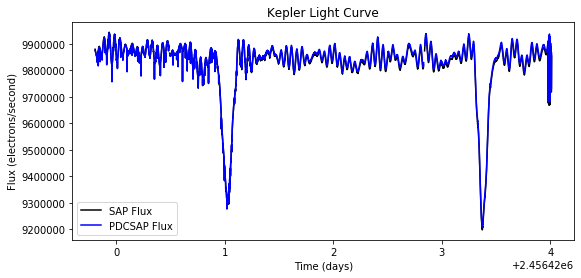

-----------------------------


kepid                     7449136
kepoi_name              K01890.01
kepler_name         Kepler-1002 b
koi_disposition         CONFIRMED
koi_pdisposition        CANDIDATE
Name: 1357, dtype: object

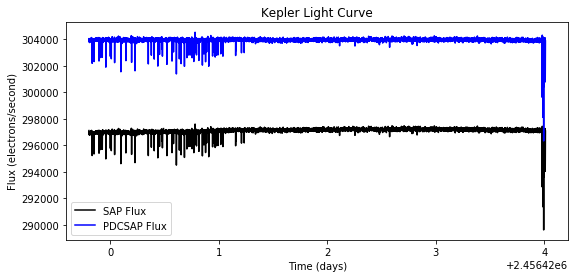

-----------------------------


kepid                      8801343
kepoi_name               K01247.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 717, dtype: object

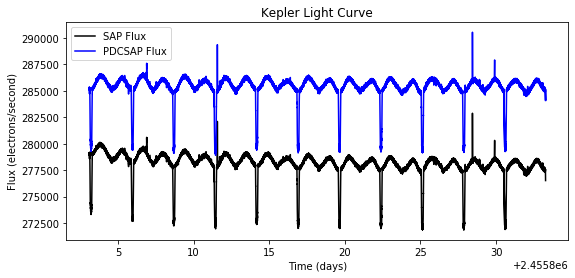

-----------------------------


kepid                      7837302
kepoi_name               K00048.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 2776, dtype: object

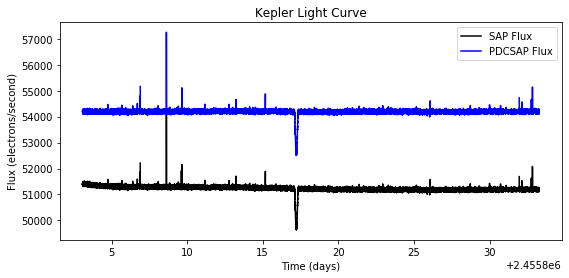

-----------------------------


kepid                   11521793
kepoi_name             K00352.01
kepler_name         Kepler-143 c
koi_disposition        CONFIRMED
koi_pdisposition       CANDIDATE
Name: 2951, dtype: object

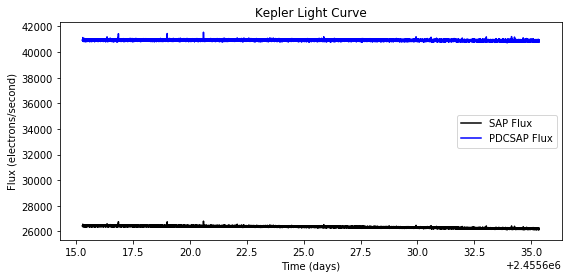

-----------------------------


kepid                     6184894
kepoi_name              K05245.01
kepler_name         Kepler-1627 b
koi_disposition         CONFIRMED
koi_pdisposition        CANDIDATE
Name: 6437, dtype: object

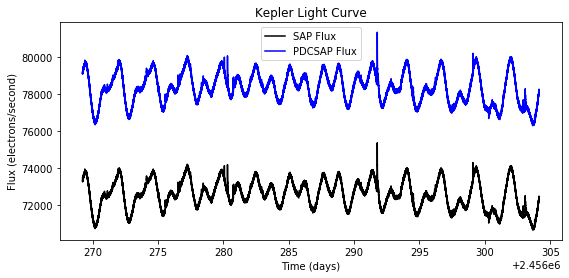

-----------------------------


kepid                    10617017
kepoi_name              K02149.01
kepler_name         Kepler-1121 b
koi_disposition         CONFIRMED
koi_pdisposition        CANDIDATE
Name: 1876, dtype: object

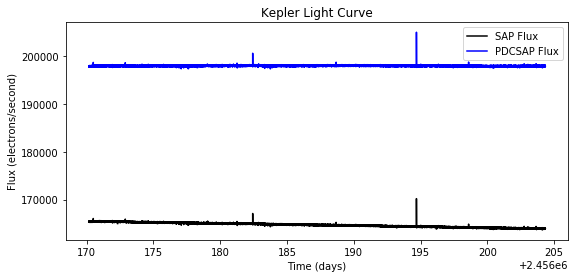

-----------------------------


kepid                      3834360
kepoi_name               K00493.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 3110, dtype: object

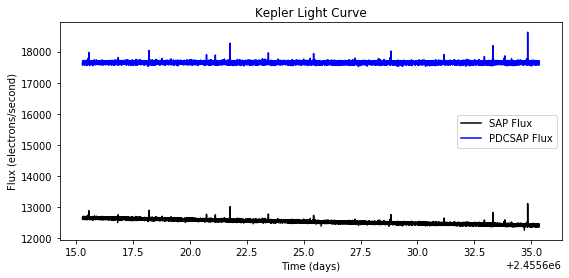

-----------------------------


kepid                   12302530
kepoi_name             K00438.01
kepler_name         Kepler-155 b
koi_disposition        CONFIRMED
koi_pdisposition       CANDIDATE
Name: 3104, dtype: object

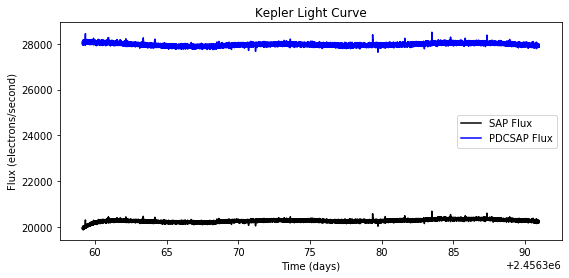

-----------------------------


kepid                      8478994
kepoi_name               K00245.04
kepler_name            Kepler-37 e
koi_disposition          CONFIRMED
koi_pdisposition    FALSE POSITIVE
Name: 2210, dtype: object

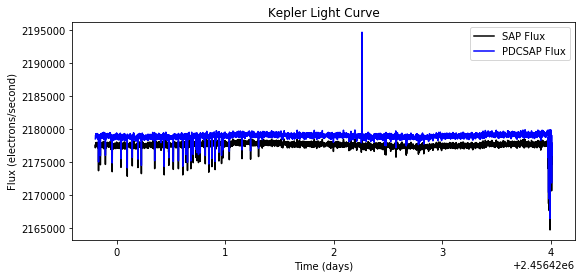

-----------------------------


kepid                    7102316
kepoi_name             K02028.02
kepler_name         Kepler-351 b
koi_disposition        CONFIRMED
koi_pdisposition       CANDIDATE
Name: 1650, dtype: object

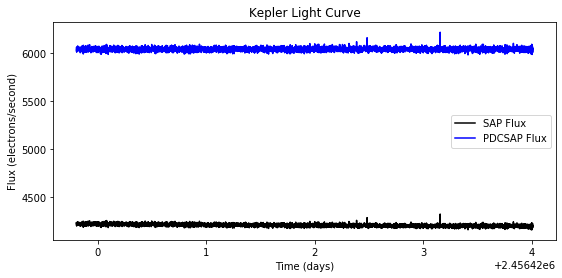

-----------------------------


kepid                      5024292
kepoi_name               K03579.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 5210, dtype: object

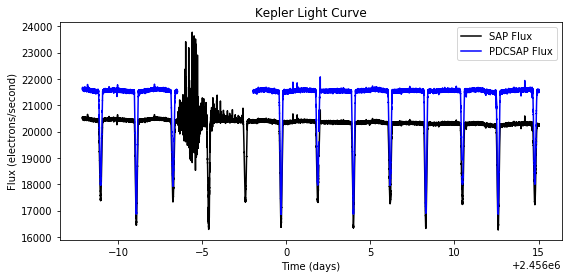

-----------------------------


kepid                    8890783
kepoi_name             K00464.02
kepler_name         Kepler-561 c
koi_disposition        CONFIRMED
koi_pdisposition       CANDIDATE
Name: 3274, dtype: object

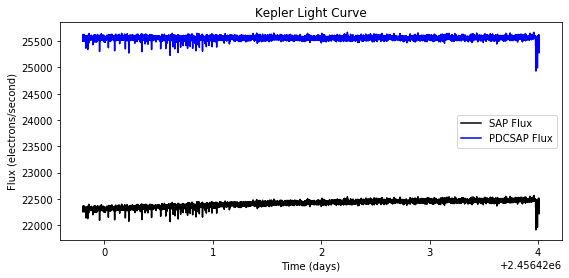

-----------------------------


kepid                    8037145
kepoi_name             K00520.01
kepler_name         Kepler-176 c
koi_disposition        CONFIRMED
koi_pdisposition       CANDIDATE
Name: 3352, dtype: object

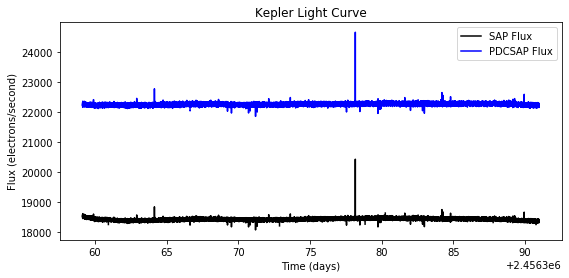

-----------------------------


kepid                      8179973
kepoi_name               K01019.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 572, dtype: object

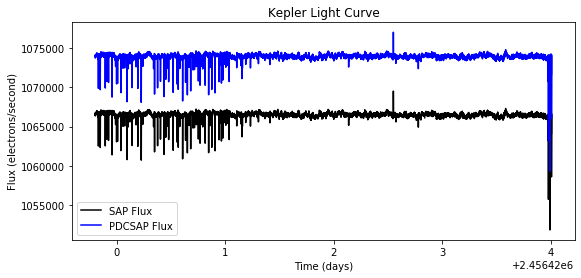

-----------------------------


In [160]:
for i in range(0, 15):
    get_random_plot_from_csv(df_koi_csv)
    print("-----------------------------")